<a href="https://colab.research.google.com/github/arthurflor23/handwritten-text-recognition/blob/master/src/tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 2 Google Drive Environment


### 2.1 TensorFlow 2.x

In [ ]:
!nvidia-smi

Mon Nov 29 14:06:44 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   73C    P8    34W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
%tensorflow_version 2.x
import tensorflow as tf

device_name = tf.test.gpu_device_name()

if device_name != "/device:GPU:0":
    raise SystemError("GPU device not found")

print("Found GPU at: {}".format(device_name))

Found GPU at: /device:GPU:0


### 2.2 Google Drive

In [ ]:
from google.colab import drive

drive.mount("./gdrive", force_remount=True)

%cd "./gdrive/My Drive/Colab Notebooks/handwritten-text-recognition/src/"
!ls -l

Mounted at ./gdrive
/content/gdrive/My Drive/Colab Notebooks/handwritten-text-recognition/src
total 848
-rw------- 1 root root  45533 Nov 23 06:26 Battung_Dobutamine_3.png
-rw------- 1 root root  33969 Nov 23 06:48 Battung_Tramadol_3.png
-rw------- 1 root root  78605 Nov 23 06:46 Dangane_Rituximab_2.png
-rw------- 1 root root  58370 Nov 23 06:13 Dasalla_Azathioprine_1.png
drwx------ 2 root root   4096 Sep 27 12:47 data
-rw------- 1 root root  38204 Nov 23 06:28 DeLosSantos_Hydroxyzine_1.png
-rw------- 1 root root  20638 Nov 23 06:24 Ferraren_Chlorpromazine_2.png
-rw------- 1 root root  53441 Nov 23 06:31 Lim_Lorazepam_1.png
-rw------- 1 root root   9074 Sep 27 12:47 main.py
-rw------- 1 root root     12 Oct 28 09:40 misclassified_words.csv
drwx------ 2 root root   4096 Sep 27 12:47 network
-rw------- 1 root root  44270 Nov 23 06:44 PayuranGatchalian_Risperidone_1.png
-rw------- 1 root root  58354 Nov 23 07:54 predict.ipynb
-rw------- 1 root root  35786 Nov 23 06:37 Ragab_Prednisolone_1

After mount, you can see the list os files in the project folder.

## 3 Set Python Classes

### 3.1 Environment

In [ ]:
import os
import datetime
import string

# define parameters
source = "doctors"
arch = "cnn_bilstm"
epochs = 200
batch_size = 16

# define paths
source_path = os.path.join("..", "data", f"{source}.hdf5")
output_path = os.path.join("..", "output", source, arch, "simpler no noise ced with seed")
target_path = os.path.join(output_path, "checkpoint_weights.hdf5")
os.makedirs(output_path, exist_ok=True)

# define input size, number max of chars per line and list of valid chars
input_size = (1024, 128, 1)
max_text_length = 128
charset_base = string.printable[:95]

print("source:", source_path)
print("output", output_path)
print("target", target_path)
print("charset:", charset_base)

source: ../data/doctors.hdf5
output ../output/doctors/cnn_bilstm/simpler no noise ced with seed
target ../output/doctors/cnn_bilstm/simpler no noise ced with seed/checkpoint_weights.hdf5
charset: 0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~ 


### 3.2 DataGenerator Class

In [ ]:
from data.generator import DataGenerator

dtgen = DataGenerator(source=source_path,
                      batch_size=batch_size,
                      charset=charset_base,
                      max_text_length=max_text_length)

print(f"Train images: {dtgen.size['train']}")
print(f"Validation images: {dtgen.size['valid']}")
print(f"Test images: {dtgen.size['test']}")

Train images: 1848
Validation images: 35
Test images: 148


In [ ]:
ground = [x for x in dtgen.dataset['test']['gt']]
print(ground)

[b'Metronidazole: 7.5 mg/kg Per os q6hr', b'Dobutamine: 2.5-15 mcg/kg/min', b'Lorazepam: 1 mg Per os 2 times a day', b'Quinine: 648 mg Per os every 8 hours for 7 days', b'Chlorpromazine: 10-25 mg Per os three times a day', b'Dobutamine: 2.5-15 mcg/kg/min', b'Chlorpromazine: 10-25 mg Per os three times a day', b'Ceftriaxone: 2 g IV q24h', b'Metronidazole: 7.5 mg/kg Per os q6hr', b'Chlorpromazine: 10-25 mg Per os three times a day', b'Lorazepam: 1 mg Per os 2 times a day', b'Risperidone: 2 mg orally i/d', b'Tramadol: 50-100 mg as needed every 4 to 6 hours', b'Risperidone: 2 mg orally i/d', b'Prednisolone: 5-60 mg per day qds', b'Risperidone: 2 mg orally i/d', b'Rituximab: 375 mg/m2 IV once weekly', b'Lorazepam: 1 mg Per os 2 times a day', b'Quinine: 648 mg Per os every 8 hours for 7 days', b'Prednisolone: 5-60 mg per day qds', b'Chlorpromazine: 10-25 mg Per os three times a day', b'Azathioprine: 3-5 mg/kg Per os OD', b'Prednisolone: 5-60 mg per day qds', b'Lorazepam: 1 mg Per os 2 times 

### 3.3 HTRModel Class

In [ ]:
from network.model import HTRModel

# create and compile HTRModel
model = HTRModel(architecture=arch,
                 input_size=input_size,
                 vocab_size=dtgen.tokenizer.vocab_size,
                 beam_width=10,
                 stop_tolerance=20,
                 reduce_tolerance=15)

model.compile(learning_rate=0.001, initial_step=0, target="model.jpg", output=output_path,)
model.summary(output_path, "summary.txt")

# get default callbacks and load checkpoint weights file (HDF5) if exists
model.load_checkpoint(target=target_path)

callbacks = model.get_callbacks(logdir=output_path, checkpoint=target_path, verbose=1)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 1024, 128, 1)]    0         
                                                                 
 conv2d (Conv2D)             (None, 1024, 128, 16)     160       
                                                                 
 batch_normalization (BatchN  (None, 1024, 128, 16)    64        
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 1024, 128, 16)     2320      
                                                                 
 batch_normalization_1 (Batc  (None, 1024, 128, 16)    64        
 hNormalization)                                                 
                                                                 
 dropout (Dropout)           (None, 1024, 128, 16)     0     

## 4 Training

In [ ]:
# to calculate total and average time per epoch
start_time = datetime.datetime.now()

h = model.fit(x=dtgen.next_train_batch(),
              epochs=epochs,
              steps_per_epoch=dtgen.steps['train'],
              validation_data=dtgen.next_valid_batch(),
              validation_steps=dtgen.steps['valid'],
              callbacks=callbacks,
              shuffle=True,
              verbose=1)

total_time = datetime.datetime.now() - start_time

loss = h.history['loss']
val_loss = h.history['val_loss']

min_val_loss = min(val_loss)
min_val_loss_i = val_loss.index(min_val_loss)

time_epoch = (total_time / len(loss))
total_item = (dtgen.size['train'] + dtgen.size['valid'])

t_corpus = "\n".join([
    f"Total train images:      {dtgen.size['train']}",
    f"Total validation images: {dtgen.size['valid']}",
    f"Batch:                   {dtgen.batch_size}\n",
    f"Total time:              {total_time}",
    f"Time per epoch:          {time_epoch}",
    f"Time per item:           {time_epoch / total_item}\n",
    f"Total epochs:            {len(loss)}",
    f"Best epoch               {min_val_loss_i + 1}\n",
    f"Training loss:           {loss[min_val_loss_i]:.8f}",
    f"Validation loss:         {min_val_loss:.8f}"
])

with open(os.path.join(output_path, "train.txt"), "w") as lg:
    lg.write(t_corpus)
    print(t_corpus)

Epoch 1/200
116/116 [==============================] - ETA: 0s - loss: 130.2279 - accuracy: 2.2406e-04
Epoch 00001: val_loss improved from inf to 617.35785, saving model to ../output/doctors/cnn_bilstm/!simpler no preproc with seed/checkpoint_weights.hdf5
116/116 [==============================] - 64s 388ms/step - loss: 130.2279 - accuracy: 2.2406e-04 - val_loss: 617.3578 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 2/200
116/116 [==============================] - ETA: 0s - loss: 103.2532 - accuracy: 0.0014
Epoch 00002: val_loss improved from 617.35785 to 580.93469, saving model to ../output/doctors/cnn_bilstm/!simpler no preproc with seed/checkpoint_weights.hdf5
116/116 [==============================] - 42s 358ms/step - loss: 103.2532 - accuracy: 0.0014 - val_loss: 580.9347 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 3/200
116/116 [==============================] - ETA: 0s - loss: 91.6032 - accuracy: 0.0029
Epoch 00003: val_loss improved from 580.93469 to 474.34653, saving model t

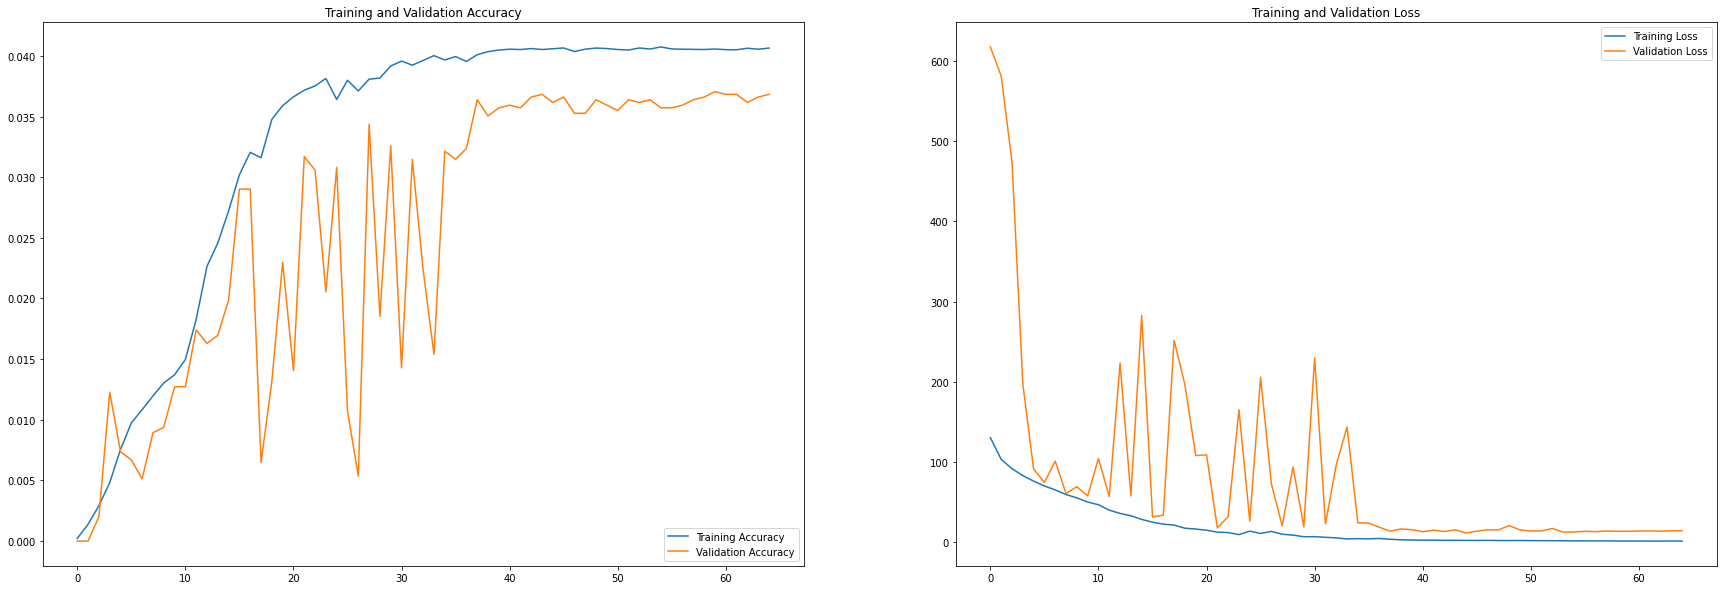

In [ ]:
from matplotlib import pyplot as plt

# import pandas as pd
# log_data = open(os.path.join(output_path, "epochs.log")).read().splitlines()
# loss =[]
# val_loss=[]
# i = 0
# for line in log_data:
#   i =i+1
#   print(i)
#   split = line.split(";")
#   if split[1].find("loss") == -1:
#     loss.append(float(split[1]))
#   if split[2].find("val_loss") == -1:
#     val_loss.append(float(split[2]))

loss = h.history['loss']
val_loss = h.history['val_loss']


epochs_range = range(65)

plt.figure(figsize=(30, 10))

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## 5 Predict

The predict process is similar to the *predict* of the Keras:

Model Predict
10/10 [==============================] - 15s 1s/step
CTC Decode
 1/10 [==>...........................] - ETA: 6s

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


10/10 [==============================] - 7s 733ms/step



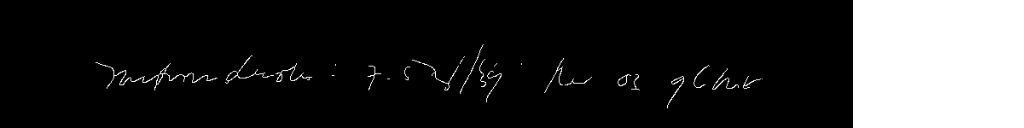

Metronidazole: 7.5 mg/kg Per os q6hr
Metronidazole: 7.5 mg/kg Per os q6hr 




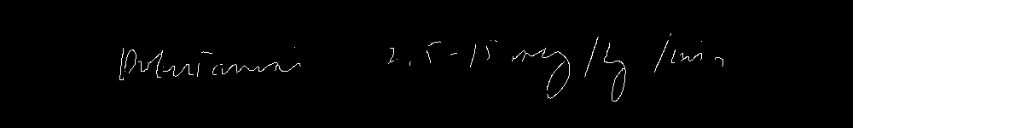

Dobutamine: 2.5-15 mcg/kg/min
Dobutamine: 2.5-15 mcg/kg/min 




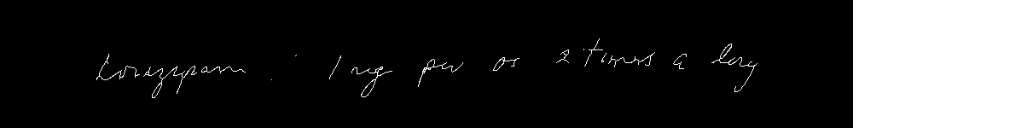

Lorazepam: 1 mg Per os 2 times a day
Lorazepam: 1 mg Per os 2 times a day 




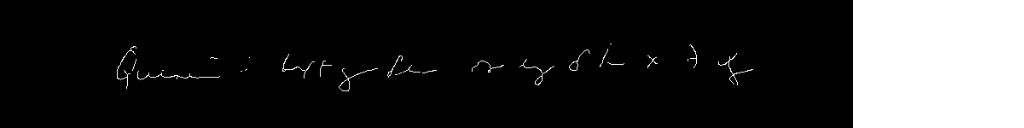

Quinine: 648 mg Per os every 8 hours for 7 days
Quinine: 648 mg Per os every 8 hours for 7 days 




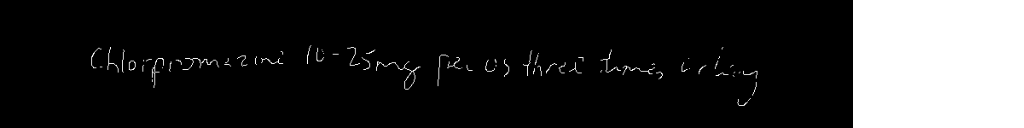

Chlorpromazine: 10-25 mg Per os three times a day
Chlorprmazine: 10-25 mg Per os three times a day 



In [ ]:
from data import preproc as pp
from google.colab.patches import cv2_imshow

start_time = datetime.datetime.now()

# predict() function will return the predicts with the probabilities
predicts, _ = model.predict(x=dtgen.next_test_batch(),
                            steps=dtgen.steps['test'],
                            ctc_decode=True,
                            verbose=1)

predicts = [dtgen.tokenizer.decode(x[0]) for x in predicts]
ground_truth = [x.decode() for x in dtgen.dataset['test']['gt']]

total_time = datetime.datetime.now() - start_time

# mount predict corpus file
with open(os.path.join(output_path, "predict.txt"), "w") as lg:
    for pd, gt in zip(predicts, ground_truth,):
        lg.write(f"TE_L {gt}\nTE_P {pd}\n")
   
for i, item in enumerate(dtgen.dataset['test']['dt'][:5]):
    print("=" * 1024, "\n")
    cv2_imshow(pp.adjust_to_see(item))
    print(ground_truth[i])
    print(predicts[i], "\n")

## 6 Evaluate

Evaluation process is more manual process. Here we have the `ocr_metrics`, but feel free to implement other metrics instead. In the function, we have three parameters: 

* predicts
* ground_truth
* norm_accentuation (calculation with/without accentuation)
* norm_punctuation (calculation with/without punctuation marks)

In [ ]:
!pip install pyastronomy
from data import evaluation

cer, evaluate, acc, labels = evaluation.ocr_metrics(predicts, ground_truth, output_path)

e_corpus = "\n".join([
    f"Total test images:    {dtgen.size['test']}",
    f"Total time:           {total_time}",
    f"Time per item:        {total_time / dtgen.size['test']}\n",
    f"Metrics:",
    f"Character Error Rate:       {evaluate[0]:.8f}",
    f"Word Error Rate:            {evaluate[1]:.8f}",
    f"f1-score:                   {evaluate[2]:.8f}",
    f"Recall:                     {evaluate[3]:.8f}",
    f"Precision:                  {evaluate[4]:.8f}",
    f"F1 score:                   {evaluate[5]:.8f}",
    f"CER: {cer}",
    f"azathioprine accuracy:      {acc[0]}",
    f"ceftriaxone accuracy:       {acc[1]}",
    f"chlorpromazine accuracy:    {acc[2]}",
    f"dobutamine accuracy:        {acc[3]}",
    f"hydroxyzine accuracy:       {acc[4]}",
    f"lorazepam accuracy:         {acc[5]}",
    f"metronidazole accuracy:     {acc[6]}",
    f"prednisolone accuracy:      {acc[7]}",
    f"quinine accuracy:           {acc[8]}",
    f"risperidone accuracy:       {acc[9]}",
    f"rituximab accuracy:         {acc[10]}",
    f"tramadol accuracy:          {acc[11]}",
    f"azathioprine recall:      {labels[0][0]}",
    f"ceftriaxone recall:       {labels[0][1]}",
    f"chlorpromazine recall:    {labels[0][2]}",
    f"dobutamine recall:        {labels[0][3]}",
    f"hydroxyzine recall:       {labels[0][4]}",
    f"lorazepam recall:         {labels[0][5]}",
    f"metronidazole recall:     {labels[0][6]}",
    f"prednisolone recall:      {labels[0][7]}",
    f"quinine recall:           {labels[0][8]}",
    f"risperidone recall:       {labels[0][9]}",
    f"rituximab recall:         {labels[0][10]}",
    f"tramadol recall:          {labels[0][11]}",
    f"azathioprine precision:      {labels[1][0]}",
    f"ceftriaxone precision:       {labels[1][1]}",
    f"chlorpromazine precision:    {labels[1][2]}",
    f"dobutamine precision:        {labels[1][3]}",
    f"hydroxyzine precision:       {labels[1][4]}",
    f"lorazepam precision:         {labels[1][5]}",
    f"metronidazole precision:     {labels[1][6]}",
    f"prednisolone precision:      {labels[1][7]}",
    f"quinine precision:           {labels[1][8]}",
    f"risperidone precision:       {labels[1][9]}",
    f"rituximab precision:         {labels[1][10]}",
    f"tramadol precision:          {labels[1][11]}",
    f"azathioprine f1-score:      {labels[2][0]}",
    f"ceftriaxone f1-score:       {labels[2][1]}",
    f"chlorpromazine f1-score:    {labels[2][2]}",
    f"dobutamine f1-score:        {labels[2][3]}",
    f"hydroxyzine f1-score:       {labels[2][4]}",
    f"lorazepam f1-score:         {labels[2][5]}",
    f"metronidazole f1-score:     {labels[2][6]}",
    f"prednisolone f1-score:      {labels[2][7]}",
    f"quinine f1-score:           {labels[2][8]}",
    f"risperidone f1-score:       {labels[2][9]}",
    f"rituximab f1-score:         {labels[2][10]}",
    f"tramadol f1-score:          {labels[2][11]}",
    f"azathioprine CER:      {labels[3][0]}",
    f"ceftriaxone CER:       {labels[3][1]}",
    f"chlorpromazine CER:    {labels[3][2]}",
    f"dobutamine CER:        {labels[3][3]}",
    f"hydroxyzine CER:       {labels[3][4]}",
    f"lorazepam CER:         {labels[3][5]}",
    f"metronidazole CER:     {labels[3][6]}",
    f"prednisolone CER:      {labels[3][7]}",
    f"quinine CER:           {labels[3][8]}",
    f"risperidone CER:       {labels[3][9]}",
    f"rituximab CER:         {labels[3][10]}",
    f"tramadol CER:          {labels[3][11]}",
    f"azathioprine WER:      {labels[4][0]}",
    f"ceftriaxone WER:       {labels[4][1]}",
    f"chlorpromazine WER:    {labels[4][2]}",
    f"dobutamine WER:        {labels[4][3]}",
    f"hydroxyzine WER:       {labels[4][4]}",
    f"lorazepam WER:         {labels[4][5]}",
    f"metronidazole WER:     {labels[4][6]}",
    f"prednisolone WER:      {labels[4][7]}",
    f"quinine WER:           {labels[4][8]}",
    f"risperidone WER:       {labels[4][9]}",
    f"rituximab WER:         {labels[4][10]}",
    f"tramadol WER:          {labels[4][11]}",
])
with open(os.path.join(output_path, "evaluate.txt"), "w") as lg:
    lg.write(e_corpus)
    print(e_corpus)


     |████████████████████████████████| 727 kB 8.2 MB/s 
     |████████████████████████████████| 85 kB 5.1 MB/s 
  Created wheel for pyastronomy: filename=PyAstronomy-0.17.0-py3-none-any.whl size=522050 sha256=737e7313ec77c0c7b3ffd8b3075ed705a81b986e196a023f252172e6fc96649f
  Stored in directory: /root/.cache/pip/wheels/10/f4/cc/fe117c538c81443a6ba0e852ee8d69866a08e5163d2050aae5
  Created wheel for quantities: filename=quantities-0.12.5-py3-none-any.whl size=80135 sha256=a4ef256e2dea67267b8a6bfad1b7eb7645c35bd5a78c36d7b55066b4a8e160df
  Stored in directory: /root/.cache/pip/wheels/67/e7/32/0bb6d5bd0f619e583b6f1f4c710b535df898a1083e1e5d066c
Successfully built pyastronomy quantities
Total test images:    148
Total time:           0:00:29.457390
Time per item:        0:00:00.199036

Metrics:
Character Error Rate:       0.05433013
Word Error Rate:            0.09772045
f1-score:                   72.29729730
Recall:                     89.97050147
Precision:                  90.05905512
F1